<center>

# __8. Simulations with noise__

November 26, 2023

<br>

__Herramientas de la Computación Cuántica__

__Máster en Ciencia y Tecnologías de Información Cuántica (MQIST)__

<br>

Diego Alvarez-Estevez, PhD.

_Centro de Investigación en Tecnologías de la Información y las Comunicaciones (CITIC)_

_Universidade da Coruña_

</center>

In [2]:
# Version checking
from qiskit_aer import Aer
import qiskit.tools.jupyter

import sys
print(sys.executable)

%qiskit_version_table

/usr/local/bin/python


## Adding noise to the simulations with Aer

As introduced in past sections, Aer provides functionality to run quantum circuit using noisy simulations

As we might already know, execution in real quantum computers is still far from ideal, and this is part of the reason to start testing algorithms using simulators. In today's Noisy Intermediate-Scale Quantum (NISQ) era, the amount of errors on a device could be significant, depending on the quantum circuit executed on them.

With Aer, noise models can be used to represent various noise effects that cause errors in real quantum circuits. These noise models can be extracted from configuration information from real devices, or can be customized, created from scratch. Either way, the noise model can be then plugged back into the simulator to run a noisy simulation. This can be interesting for several reasons, for example:

-Test performance of our algorithm in advance to execution in real devices (whereby execution time is much more expensive, e.g. queues) 

-Test robutness of an algorithm for optimization towards diverse noisy situations

-Test error correction and mitigration techniques 

There are several types and/or sources of errors that can affect stability of one to several qubits, gate operations, and measurement readouts. Let us examine some of the most important ones:

## Decoherence (characterized by _T1_ and _T2_ times)

**Decoherence** is a general term defined as the loss of quantum coherence due to a quantum system's physical interaction with its environment. There are usually two main different source types of noise affecting decoherence: **intrinsic** and **extrinsic**. **Intrincis noise** originates from sources within the system such as temperature, or defects of the construction materials. **Extrinsic noise** originates from environmentally coupled systems such as wave interference, vibrations, electromagnetic fields, and similar ones exterior to the quantum system itself.  

Decoherence affects each qubit in many varying ways. For example, qubits are usually initialized at |0>, i.e. in the ground state. We can then operate on a qubit (e.g. bit-flip) to move it from the ground -relaxed- state to the "excited" |1> state. However, because the several physical interaction with the environment, after certain time the qubit will start to "relax", going back to its ground state. This time is usually referred to as the "relaxation time", also denoted as _T1_. More specifically, _T1_ is the time constant of the longitudinal loss (oriented along the z-axis of the Bloch sphere) of the signal intensity.

Another decoherence effect is that of dephasing, i.e. a measure of how phase information of a qubit is lost through time. This is characterized by time constant _T2_. For example, a phase change can unexpectably take place when the state |+> progressively decays down to a mixed state of |+> and |->. Thus, if the running time for a circuit starts to approach the T2 time one would expect to observe phase errors affecting the quality of readout data.

_T1_ and _T2_ times for a real device could be measured by different ways. For example, using pulse waves to measure _T1_, one could apply a series of pulses for exciting a qubit separated by a fixed time delay and capture the statistical results. This is usually done trough a method called **Rabi oscillations**. For _T2_, one could set the qubit to |+> or |-> and then apply $\pi$ pulses at particular sequences to apply a phase rotation. After applying a particular sequence of pulses over time, the state should return to its original position. If dephasing occurs, then the result will have a lower probability of returning to its original starting position. This technique of measuring _T2_ is called **spin echo**.

We could also try the following experiment using Qiskit <u>with a real device</u> to experience the effects of thermal relaxation:

1. Initialise the qubit to |1〉using a Pauli-X gate

2. Add a delay to the circuit 

3. Measure the qubit state 

The longer the delay the more measurements there will be for |0〉due to thermal relaxation: 

Job Status: job has successfully run


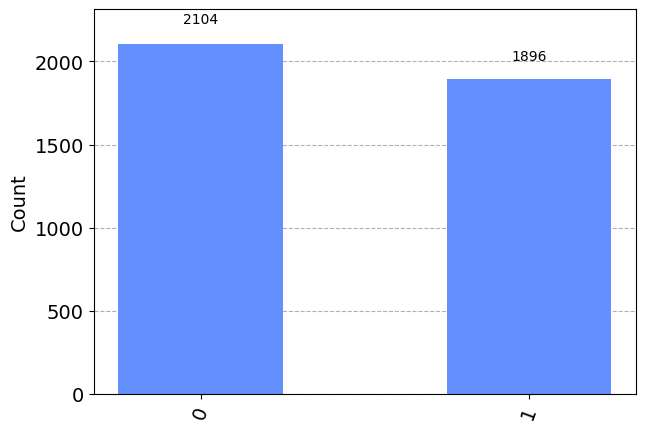

In [3]:
# Note running this code might involve waiting in queue
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_provider.job import job_monitor
from qiskit.visualization import plot_histogram

# Set delay time (in microseconds)
delay_time = 200

# Prepare one-single qubit circuit initialized to |1>
qc = QuantumCircuit(1)
qc.x(0)
qc.delay(delay_time, unit="us") # add delay
qc.measure_all()

ibm_provider = IBMProvider()
backend = least_busy(ibm_provider.backends(min_num_qubits=2, simulator=False, operational=True))

tqc = transpile(qc, backend)

ibm_job = backend.run(tqc)

job_monitor(ibm_job)

plot_histogram(ibm_job.result().get_counts()) # One would expect measuring 1 all the time if no error is present

Job Status: job has successfully run


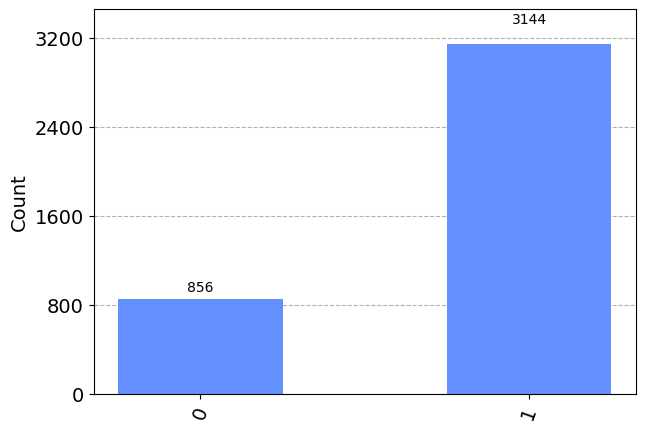

In [4]:
# Now  using delay = 0
# Note running this code might involve waiting in queue

# Set delay time (in microseconds)
delay_time = 0

# Prepare one-single qubit circuit initialized to |1>
qc = QuantumCircuit(1)
qc.x(0)
qc.delay(delay_time, unit="us") # add delay
qc.measure_all()

# Use same backend
#ibm_provider = IBMProvider()
#backend = least_busy(ibm_provider.backends(min_num_qubits=2, simulator=False, operational=True))

tqc = transpile(qc, backend)

ibm_job = backend.run(tqc)

job_monitor(ibm_job)

plot_histogram(ibm_job.result().get_counts()) # One would expect measuring 1 all the time if no error is present

Using Aer, the following code allows us to simulate <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.thermal_relaxation_error.html>thermal relaxation error</a> on a pair of qubits. Note that while before we referred to _T1_ as ```relaxation time```, both _T1_ and _T2_ actually contribute to decoherence by thermal relaxation. As outlined before, more specifically _T1_ is sometimes referred to as ```longitudinal paramagnetic relaxation```, and _T2_ as ```transverse paramagnetic relaxation```:

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


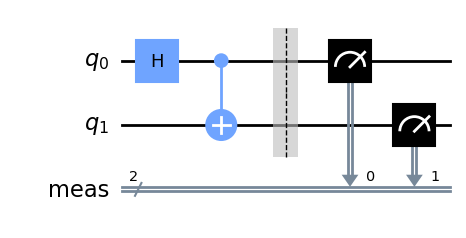

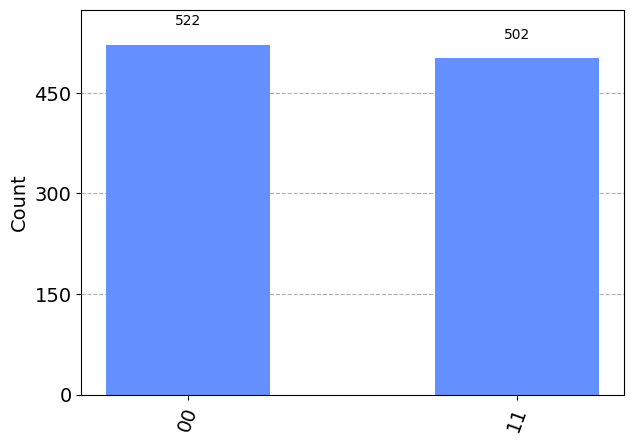

In [5]:
# First run the circuit with ideal simulation
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Create the circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

display(qc.draw("mpl"))

sim = Aer.get_backend("aer_simulator")

# Transpile circuit and run the circuit
tqc = transpile(qc, sim)
result = sim.run(tqc).result()

# Get and plot counts
counts_sim = result.get_counts(0)
plot_histogram(counts_sim)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['id', 'u1', 'u3', 'u2']
  All-qubits errors: ['id', 'u1', 'u2', 'u3']


/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


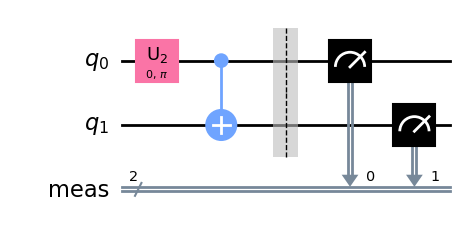

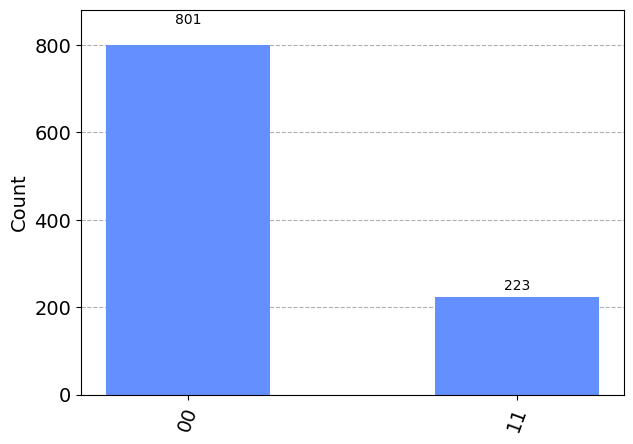

In [6]:
# Now run it again with added thermal relaxation noise
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

# Initialize your T1 and T2 values
t1 = 0.0125 # decay constant T1
t2 = 0.0025 # decay constant T2
gate_time_for_relaxation = 0.01 # the gate time for relaxation error

# Apply the T1 and T2 to create the thermal relaxation error
t_error = thermal_relaxation_error(t1, t2, gate_time_for_relaxation)

# Add the errors to a noise model 
# and apply to all basis gates on all qubits
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(t_error, ['id', 'u1', 'u2', 'u3'])

# Print out the noise model 
print(noise_model) 

# Set the simulator with the noise model
sim_thermal = Aer.get_backend("aer_simulator")
sim_thermal.set_option("noise_model", noise_model)
# Alternatively
#from qiskit_aer import AerSimulator
#sim_thermal = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim_thermal)

# Uncomment these two instructions to include addigional debugging information for better understanding
#print(sim_thermal.configuration().to_dict().get('basis_gates'))
display(tqc.draw("mpl"))

# Run and get counts
result_thermal = sim_thermal.run(tqc).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

Carefully analyze the results and instructions used in the previous piece of code. 

In general, the Qiskit Aer's [noise module](https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html) contains Python classes to build customized noise models for simulation. There are three key classes:

1. The <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.NoiseModel.html>NoiseModel</a> class which stores a noise model used for noisy simulation.

2. The <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.QuantumError.html#qiskit_aer.noise.QuantumError>QuantumError</a> class which describes CPTP gate errors (a way to model quantum errors by quantum process matrices, or CPTP maps). These can be applied:

    * After *gate* or *reset* instructions
    
    * Before *measurement* instructions.

    However, rather than dealing with the QuantumError object directly, many <a href=https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html#quantum-error-functions>helper functions contained in the noise module</a> exist to automatically generate a specific type of parameterized quantum error

3. The <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.ReadoutError.html#qiskit_aer.noise.ReadoutError>ReadoutError</a> class which describes classical readout errors.

You might have observed, in the previous code snippet, the same (thermal relaxation) error (QuantumError class) was applied to any occurrence of an instruction using the [add_all_qubit_quantum_error(error, instructions)](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.NoiseModel.html#qiskit_aer.noise.NoiseModel.add_all_qubit_quantum_error) method, regardless of which qubits it acts on. Specific qubit quantum error can also be modeled using the [noise_model.add_quantum_error(error, instructions, qubits)](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.NoiseModel.html#qiskit_aer.noise.NoiseModel.add_quantum_error) method. This applies the error to any occurrence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0].

Single-gate and multi-gate errors are generally those introduced when a qubit is operated upon by the various gates on the system. These errors are based on probabilities that the gate applied to the qubit(s) may not operate exactly as expected. For example, if we apply a 5% gate error probability to a single-qubit gate such as NOT gate, then the result of the operation has 5% probability of not resulting in the expected value. 

The Aer library has a list of noise model methods to choose from, including <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.pauli_error.html#qiskit_aer.noise.pauli_error>Pauli error</a> (noise model using Pauli channels, i.e. stochastic mixture of Pauli operators), <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.depolarizing_error.html#qiskit_aer.noise.depolarizing_error>depolarizing error</a>, or <a href=https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.amplitude_damping_error.html#qiskit_aer.noise.amplitude_damping_error>amplitude damping error</a>, among others.

The following piece of code show an example creating a noise model with 5% depolarizing errors on different 1-qubit and 2-qubit gates:

In [7]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

# Add depolarizing error to all two qubit cx gates on qubit 0 and 1 only
noise_model = NoiseModel()
error = depolarizing_error(0.05, 2)
noise_model.add_quantum_error(error, ['cx'], [0, 1])
#noise_model.add_quantum_error(error, ['cx'], [0]) # will produce an error, need to involve 2-qubit

# Print noise model info
print("\n", noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]

 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('cx', (0, 1))]


<span style="color:red">PRACTICE:</span> Create a 2-qubit quantum circuit that applies a NOT gate to the first qubit with a 50% depolarization error. What output shoud I expect?

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


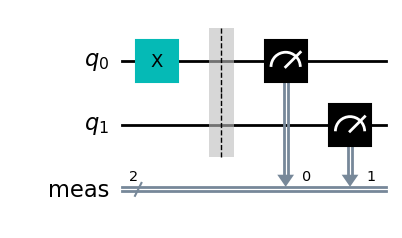

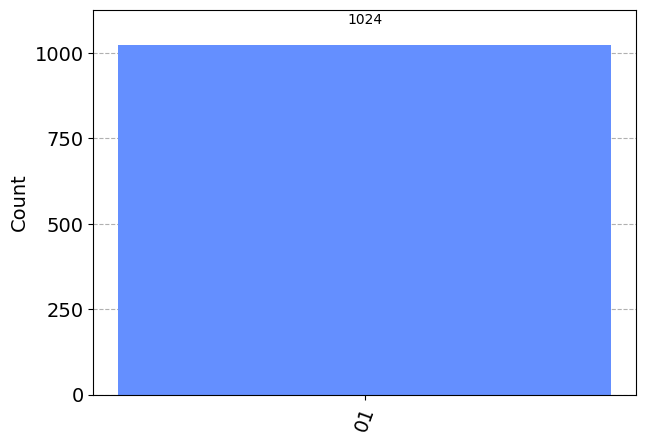

In [8]:
# First, we obtain the expected output using a noise-free (ideal) simulation
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Create the circuit
qc = QuantumCircuit(2)
qc.x(0)
qc.measure_all()

display(qc.draw("mpl")) 

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts)) # We would expect 01 all the time if no errors

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.625, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
  P(1) = 0.125, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.125, Circuit = 
   ┌───┐
q: ┤ Y ├
   └───┘
  P(3) = 0.125, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x']
  Qubits with noise: [0]
  Specific qubit errors: [('x', (0,))]


/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


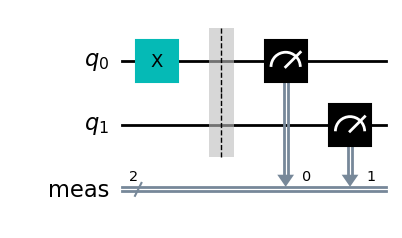

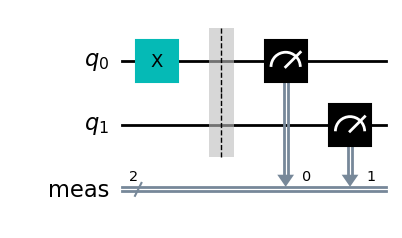

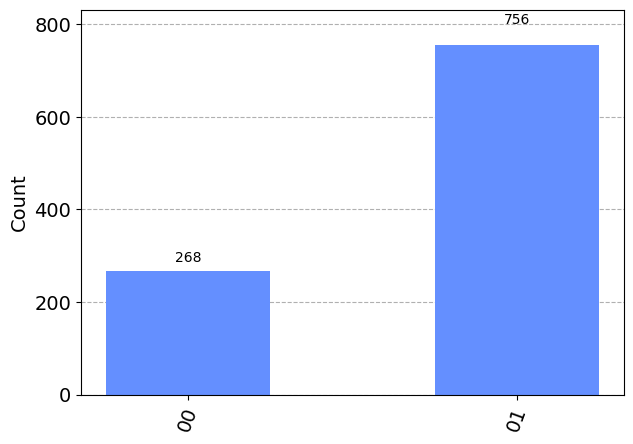

In [9]:
# Now simulate the error and interpret the results
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit x gates on qubit 0 only
error = depolarizing_error(0.5, 1)
noise_model.add_quantum_error(error, ['x'], [0])

# Print noise model info
print(error) # Key to undestand behaviour (see comments at the end)
print(noise_model)

# Create the same circuit
qc = QuantumCircuit(2)
qc.x(0)
qc.measure_all()

display(qc.draw("mpl")) 

# Set the simulator with the noise model
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim)

#print("Basis gates of transpiled circuit: ", sim.configuration().to_dict().get('basis_gates'))
display(tqc.draw("mpl"))

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts))

In [ ]:
# Fill in with your conclusions

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


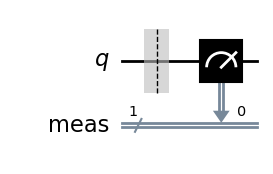

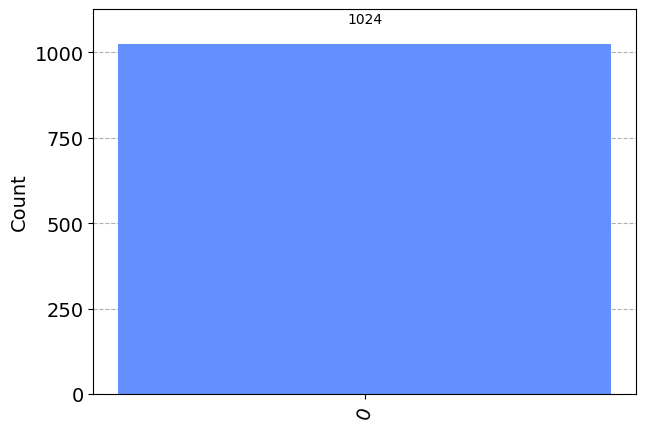

In [10]:
# Testing effect of individual X, Y, and Z gates on single qubit to explain behaviour on previous exercise
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Create the same circuit
qc = QuantumCircuit(1)
#qc.x(0) # Flips 0 to 1
#qc.y(0) # Flips 0 to 1
#qc.z(0) # Has no flipping effect (remains 0) -> https://deeplearninguniversity.com/qiskit/qiskit-z-gate/
qc.measure_all()

display(qc.draw("mpl")) 

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts))

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


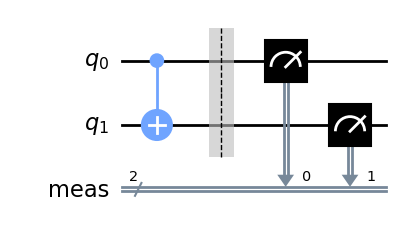

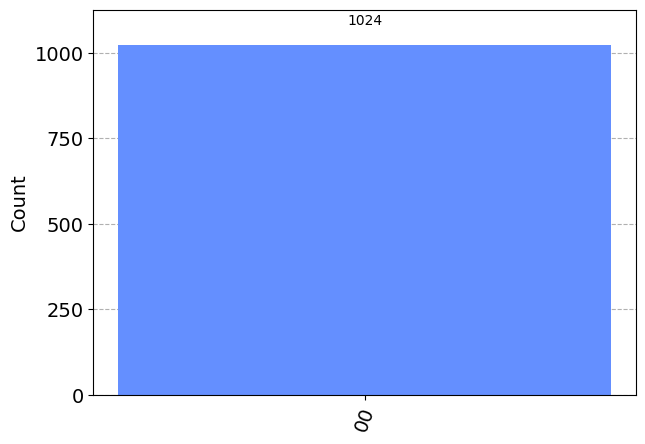

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('cx', (0, 1))]
Basis gates of transpiled circuit:  ['cx', 'id', 'rz', 'sx', 'break_loop', 'continue_loop', 'for_loop', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'switch_case', 'while_loop']


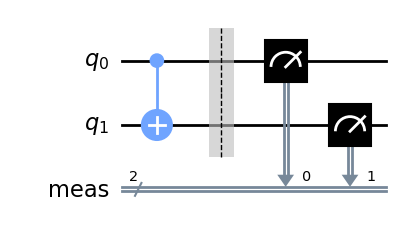

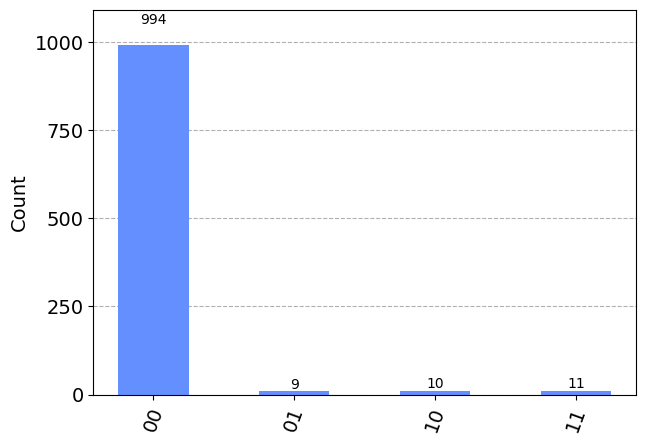

In [11]:
# Testing sentence "For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0]"
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create the same circuit
qc = QuantumCircuit(2)
qc.cx(0,1) # 1
#qc.cx(1,0) # 2
qc.measure_all() 
# We would expect 00 all the time if no errors (cnot does not apply in either case because of initial |00>)

display(qc.draw("mpl")) 

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts)) # We would expect 00 all the time if no errors

# Prepare the noise model
noise_model = NoiseModel()
error = depolarizing_error(0.05, 2)
# Following line => affects expected output counts (all 00's) only when circuit choosing #1
noise_model.add_quantum_error(error, ['cx'], [0, 1]) 
# Following line => affects expected output counts (all 00's) only when circuit choosing #2
#noise_model.add_quantum_error(error, ['cx'], [1, 0])

print("\n", noise_model)

# Set the simulator with the noise model
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim)

print("Basis gates of transpiled circuit: ", sim.configuration().to_dict().get('basis_gates'))
display(tqc.draw("mpl"))

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts)) 

The following piece of code shows an example creating a noise model using Pauli channels. More specifically: 

-When resetting a qubit reset to 1 instead of 0 (flip) with probability _p_reset_.

-When applying a single qubit gate, flip the phase of the qubit with probability _p_gate1_.

-When applying a 2-qubit gate apply single-qubit errors to each qubit.

In [12]:
from qiskit_aer.noise import NoiseModel, pauli_error

# Example error probabilities
p_reset = 0.03
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
print(error_reset)
# Alternatively
from qiskit_aer.noise import reset_error
error_reset2 = reset_error(0, p_reset)
print(error_reset2)

error_gate1 = pauli_error([('Z', p_gate1), ('I', 1 - p_gate1)])

# QuantumError instances can be combined by using composition, tensor product, and tensor expansion
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
my_noise_model = NoiseModel()
#my_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
my_noise_model.add_all_qubit_quantum_error(error_reset2, "reset") # Substitute to check equivalence
my_noise_model.add_all_qubit_quantum_error(error_gate1, ['rz', 'sx', 'x'])
my_noise_model.add_all_qubit_quantum_error(error_gate2, ['cx'])

print(my_noise_model)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.03, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.97, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.97, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
  P(1) = 0.03, Circuit = 
        ┌───┐
q: ─|0>─┤ X ├
        └───┘
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'reset', 'cx', 'x', 'sx']
  All-qubits errors: ['reset', 'rz', 'sx', 'x', 'cx']


/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


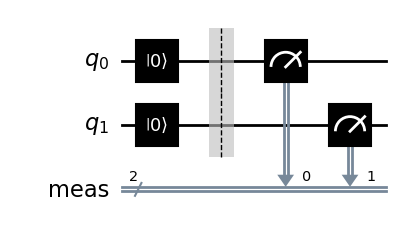

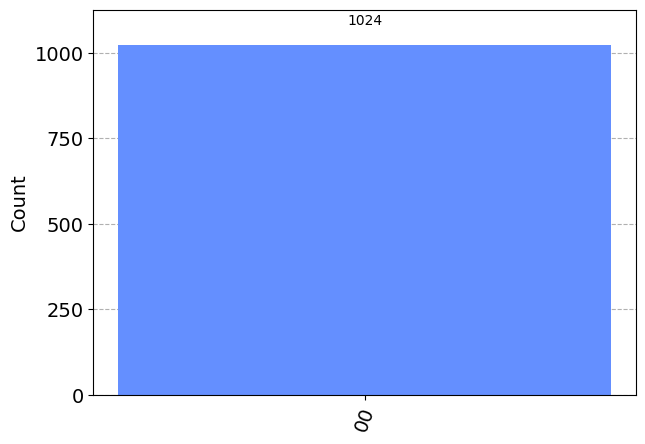

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'reset', 'cx', 'x', 'sx']
  All-qubits errors: ['reset', 'rz', 'sx', 'x', 'cx']
Basis gates of transpiled circuit:  ['cx', 'id', 'rz', 'sx', 'x', 'break_loop', 'continue_loop', 'for_loop', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'switch_case', 'while_loop']


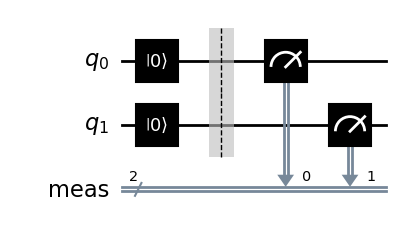

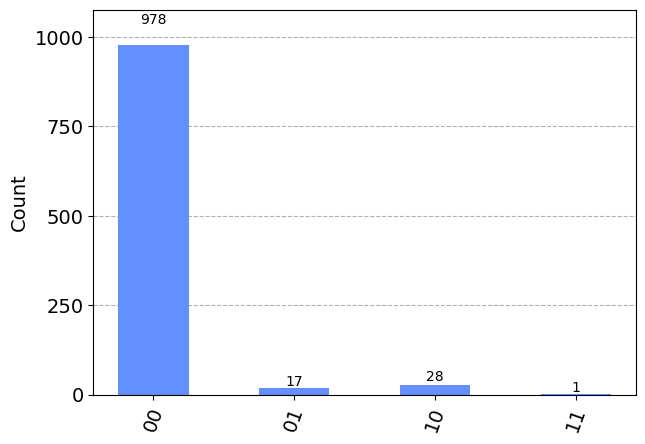

In [13]:
# Apply previous noise model to the following circuit
# Check first the effects of "reset" error
qc = QuantumCircuit(2)
qc.reset([0,1]) # Need explicit "reset" instruction, otherwise reset error will not apply (comment to check)
#qc.h(0)
#qc.cx(0,1)
qc.measure_all() # Ideally, we would expect all 00s

display(qc.draw("mpl")) 

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts))

print("\n", my_noise_model)

# Set the simulator with the noise model
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", my_noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim)

print("Basis gates of transpiled circuit: ", sim.configuration().to_dict().get('basis_gates'))
display(tqc.draw("mpl"))

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts))

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


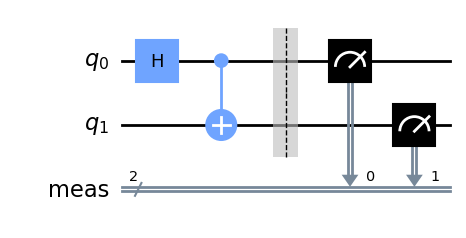

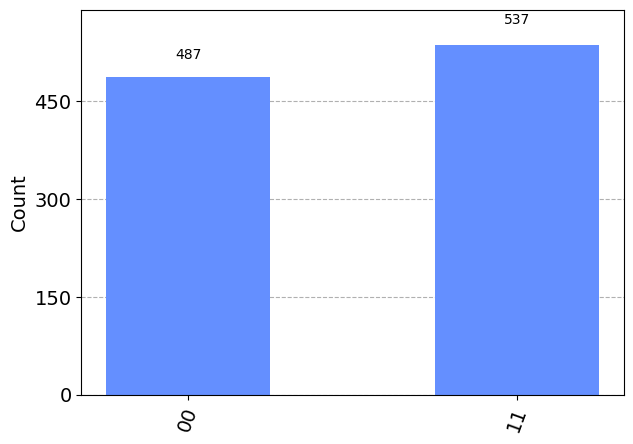

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'reset', 'cx', 'x', 'sx']
  All-qubits errors: ['reset', 'rz', 'sx', 'x', 'cx']
Basis gates of transpiled circuit:  ['cx', 'id', 'rz', 'sx', 'x', 'break_loop', 'continue_loop', 'for_loop', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'switch_case', 'while_loop']


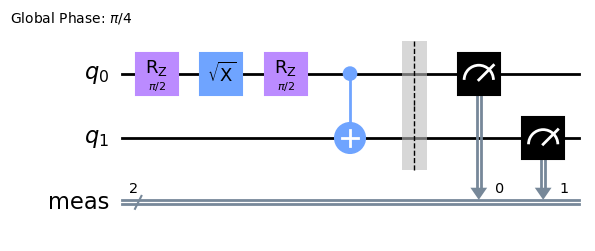

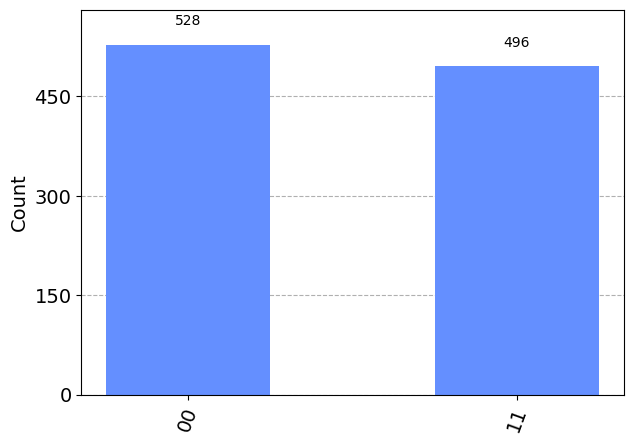

In [14]:
# Apply previous noise model to the following circuit
# What error should we get now?
qc = QuantumCircuit(2)
#qc.reset([0,1]) # Need explicit "reset" instruction, otherwise reset error will not apply
qc.h(0)
qc.cx(0,1)
qc.measure_all() # Ideally, we would expect 50% 00 and 50% 11

display(qc.draw("mpl")) 

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts))

print("\n", my_noise_model)

# Set the simulator with the noise model
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", my_noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim)

print("Basis gates of transpiled circuit: ", sim.configuration().to_dict().get('basis_gates'))
display(tqc.draw("mpl"))

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts)) # Surprisingly? Apparently not many differences

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  Qubits with noise: [1]
  Specific qubit errors: [('rz', (1,))]


/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


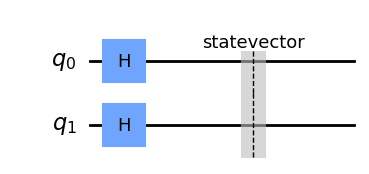

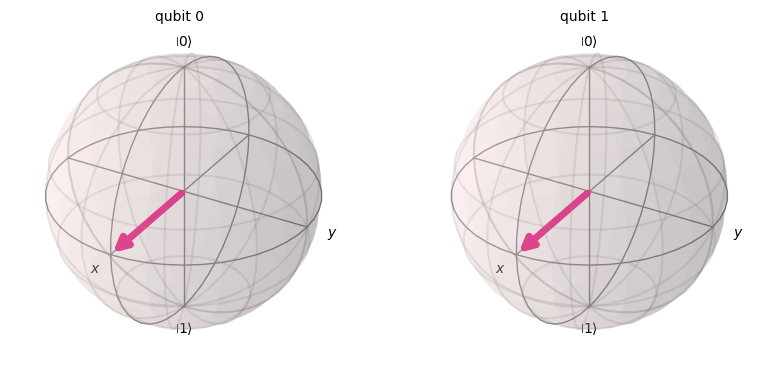

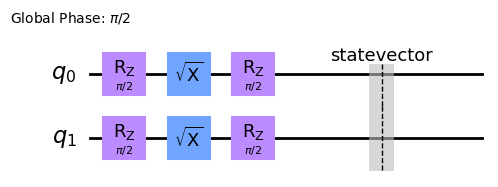

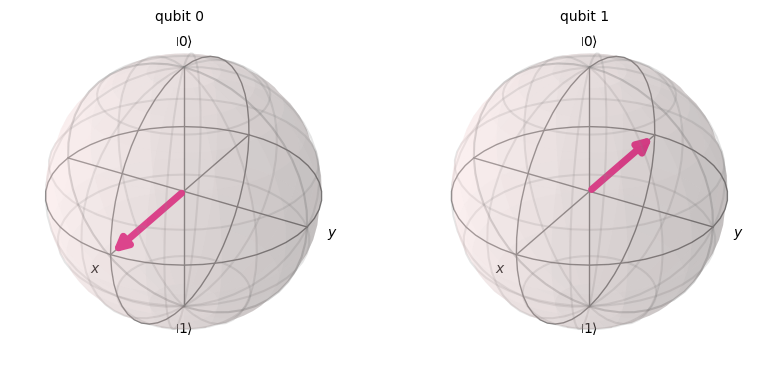

In [15]:
# Ellaborating of previous output:

# Recall phase_flip (error or not) will not influence measurement counts
# But it should influence the final phase 
# Let us monitor this difference by plotting the associated statevectors
# Important! The chances to see the error will depend on the associated error probability!

# Import the error classes and methods
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error, pauli_error
from math import pi

#p_error = 0.25 # Will only see the effect 25% of the executions
p_error = 1 # Will always see the effect
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])

# Add the single and multi-qubit errors to the noise model
noise_model = NoiseModel()
noise_model.add_quantum_error(phase_flip_error, ['rz'], [1])

# Print the noise model
print(noise_model)

# Create circuit
qc = QuantumCircuit(2)
qc.h(0) # Involves RZ after transpilation
qc.h(1) # Involves RZ after transpilation
#qc.rz(pi,1)
qc.save_statevector()

display(qc.draw("mpl"))

# Get error-free final statevectors
simulator = Aer.get_backend('aer_simulator')
tqc = transpile(qc, simulator)
#display(tqc.draw("mpl"))
result = simulator.run(tqc).result()
display(plot_bloch_multivector(result.get_statevector(tqc)))

# Get the simulator and apply the noise model
simulator = Aer.get_backend('aer_simulator')
simulator.set_options(noise_model=noise_model)
#simulator.set_option("noise_model", noise_model)

# Transpile and run
tqc = transpile(qc, simulator)
display(tqc.draw("mpl"))
result = simulator.run(tqc).result()

# Plot noisy output
display(plot_bloch_multivector(result.get_statevector(tqc)))

## Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$:

  * $A$ is the *recorded* classical bit value (what we _perceive_)
  * $B$ is the *true* bit value returned from the measurement 
 
E.g. for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$.

In [16]:
from qiskit_aer.noise import ReadoutError

# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]]) # ReadoutError supports more than 1 qubit

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

Examine the following code, that implements readout errors in a quantum circuit:

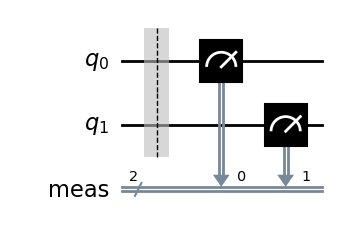

[[0.9, 0.1], [0, 1]]
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [0]
  Specific qubit errors: [('measure', (0,))]


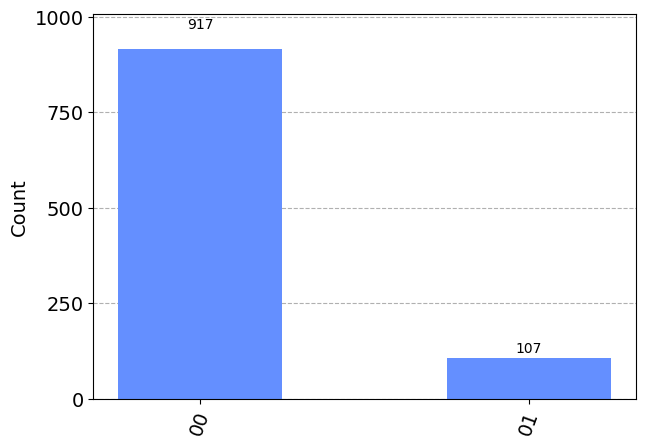

In [17]:
# Using read_out error
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, ReadoutError

# Create the same circuit
qc = QuantumCircuit(2)
qc.measure_all() # We would expect 00 all the time if no errors

display(qc.draw("mpl"))

noise_model = NoiseModel()

a = 0.9 # Prob_meas[0|0]
b = 0.1 # Prob_meas[1|0]. Notice a + b must equal 1, otherwise will raise an error
c = 0 # Prob_meas[0|1]
d = 1 # Prob_meas[1|1]. Notice c + d must equal 1, otherwise will raise an error
error_prob_matrix = [[a, b], [c, d]] # Thus if ideal output would be zero, I miss-read a "one" 10% of the time

print(error_prob_matrix)

read_out_error = ReadoutError(error_prob_matrix)
noise_model.add_readout_error(read_out_error, qubits = [0]) # Error is applied only to qubit 0

# Print out the noise model 
print(noise_model) 

# Set the simulator with the noise model
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", noise_model)

# Transpile circuit for noisy basis gates
tqc = transpile(qc, sim)

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts)) # Because error introduced we should see 01 10% of time, instead of 00 all the time

<span style="color:red">PRACTICE:</span> Using the same error model, now include an X-gate in the first qubit. What output should I expect?

/usr/local/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


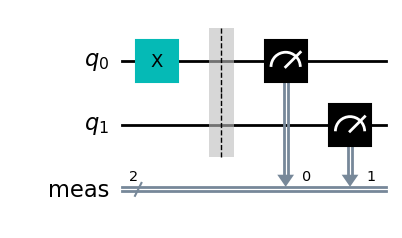

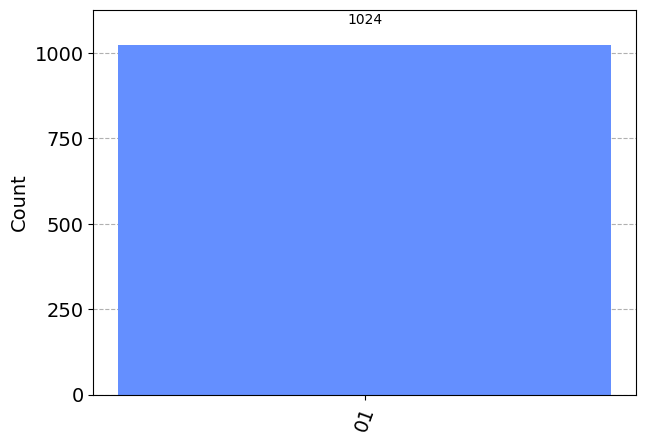

In [19]:
qc = QuantumCircuit(2)
qc.x(0)
qc.measure_all() # Then we would expect 01 all the time if no errors

display(qc.draw("mpl"))

tqc = transpile(qc, sim) # Notice this instance of simulator already incorporates the previous error model

# Run and get counts
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot noisy output
display(plot_histogram(counts)) # Because error introduced not affecting if 1, then we should keep seeing 01 all the time!

<span style="color:red">EXERCISE:</span>

Using the following circuit, compare ideal and noisy simulations using the noise model:

1. Bit-flip error affecting the first qubit with probability 0.25

2. Depolarizing error on the two-qubit CX gate with probability 0.1

3. Readout errors on the second qubit with probability of 0 given 1 of 0.7

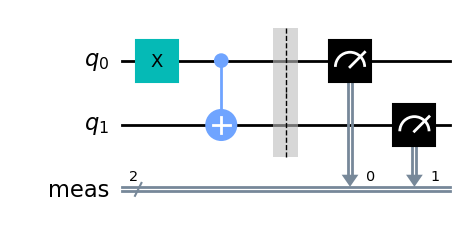

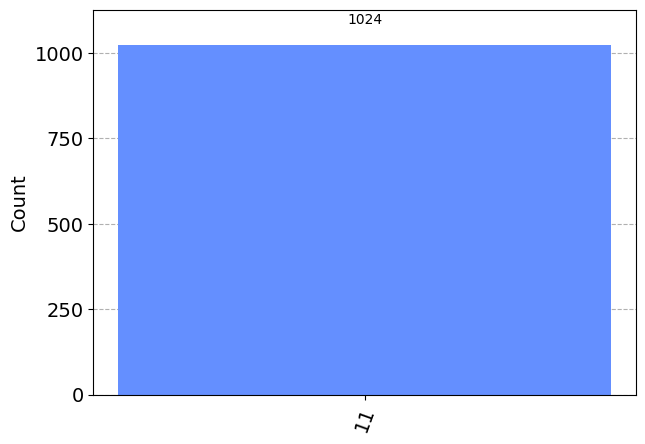

In [22]:
from qiskit import QuantumCircuit

# Create the 2 qubit Bell circuit
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0,1)
qc.measure_all()

display(qc.draw("mpl"))

# Ideal simulation
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc).result()
counts = result.get_counts(0)

# Plot ideal output
display(plot_histogram(counts))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'cx', 'x']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('x', (0,)), ('cx', (0, 1)), ('measure', (1,))]


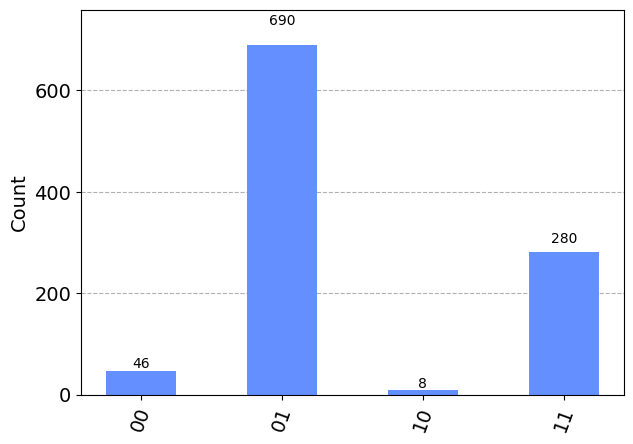

In [24]:
# Now simulate the error and interpret the results
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()

# ------------- BIT-FLIP ERROR -------------
p_error = 0.25
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
noise_model.add_quantum_error(phase_flip_error, ['x'], [0])

# ------------- DEPOLARIZING ERROR -------------
error = depolarizing_error(0.1, 2)
noise_model.add_quantum_error(error, ['cx'], [0,1])

# ------------- READOUTS ERROR -------------
error_prob_matrix = [[1, 0], [0.7, 0.3]]
read_out_error = ReadoutError(error_prob_matrix)
noise_model.add_readout_error(read_out_error, qubits = [1])

print(noise_model) 

# EXECUTE
sim = Aer.get_backend("aer_simulator")
sim.set_option("noise_model", noise_model)
tqc = transpile(qc, sim)

result = sim.run(tqc).result()
counts = result.get_counts(0)

display(plot_histogram(counts))